# Practical session n°4

Notions:
- Semantic segmentation
- Intersection over Union
- Image Denoising
- Fully convolutional networks, U-Net
- Weak supervision (in part II): The noise-to-noise and the Neural Eggs Separation scenarios.

Duration: 2 h + 2 h

In P3, we illustrated how Convolutional Neural Networks (CNNs) are trained for image classification tasks. In this practical session, we demonstrate how to achieve pixel-level predictions for tasks like semantic segmentation and image denoising.

To start, we’ll simply apply an off-the-shelf model. Then, we’ll focus on training a model from scratch (part I, exercise 2 and part II).

In P3, we also introduced a crucial set of methods known as "transfer learning," which is particularly effective when there’s limited training data. In this session, we’ll explore another equally important set of methods called "weak supervision," which is well-suited for cases where ground truth is imperfectly known (Part II).

## Part II: denoising with FCN - weakly-supervised approaches




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim
from PIL import Image

First, import the functions contained in the "utile" module.

In [5]:
! git clone https://github.com/0Yassine0/ML_S5_etudiants
! cp ML_S5_etudiants/practicals/P4/utile.py .
from utile import gen_noise2noise, voir_batch2D, UNet

fatal: destination path 'ML_S5_etudiants' already exists and is not an empty directory.


###**Exercise 1: The "noise to noise" scenario**

In Exercise 2, Part I, we had pairs (noisy version, clean version) to learn from. However, in real-world applications, clean versions are barely available. \
Sometimes, there are instances where multiple noisy versions are accessible. Consider, for example, photos taken with a telephoto lens with several seconds between shots: the effects of air turbulence on image quality are independent from one image to another. \
In the "noise to noise" scenario [(Lehtinen,2018)](https://arxiv.org/pdf/1803.04189.pdf), we have pairs of noisy images, organized into two sets $B^1_{noisy}$ and $B^2_{noisy}$.
To situate ourselves in this scenario, we utilize the synthetic images from Exercise 1. The *gen_noise2noise* function allows us to sample from both datasets:

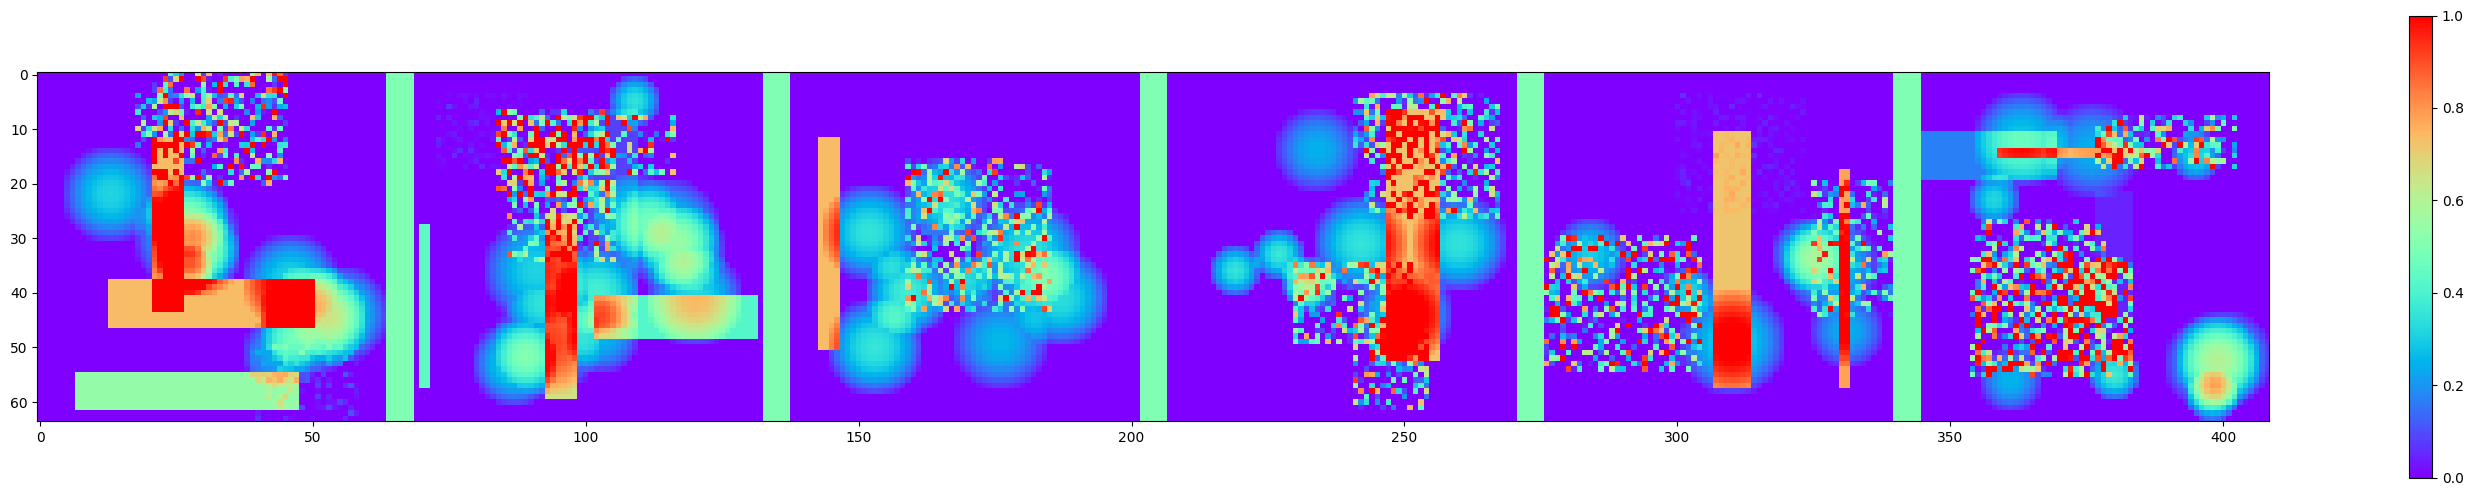

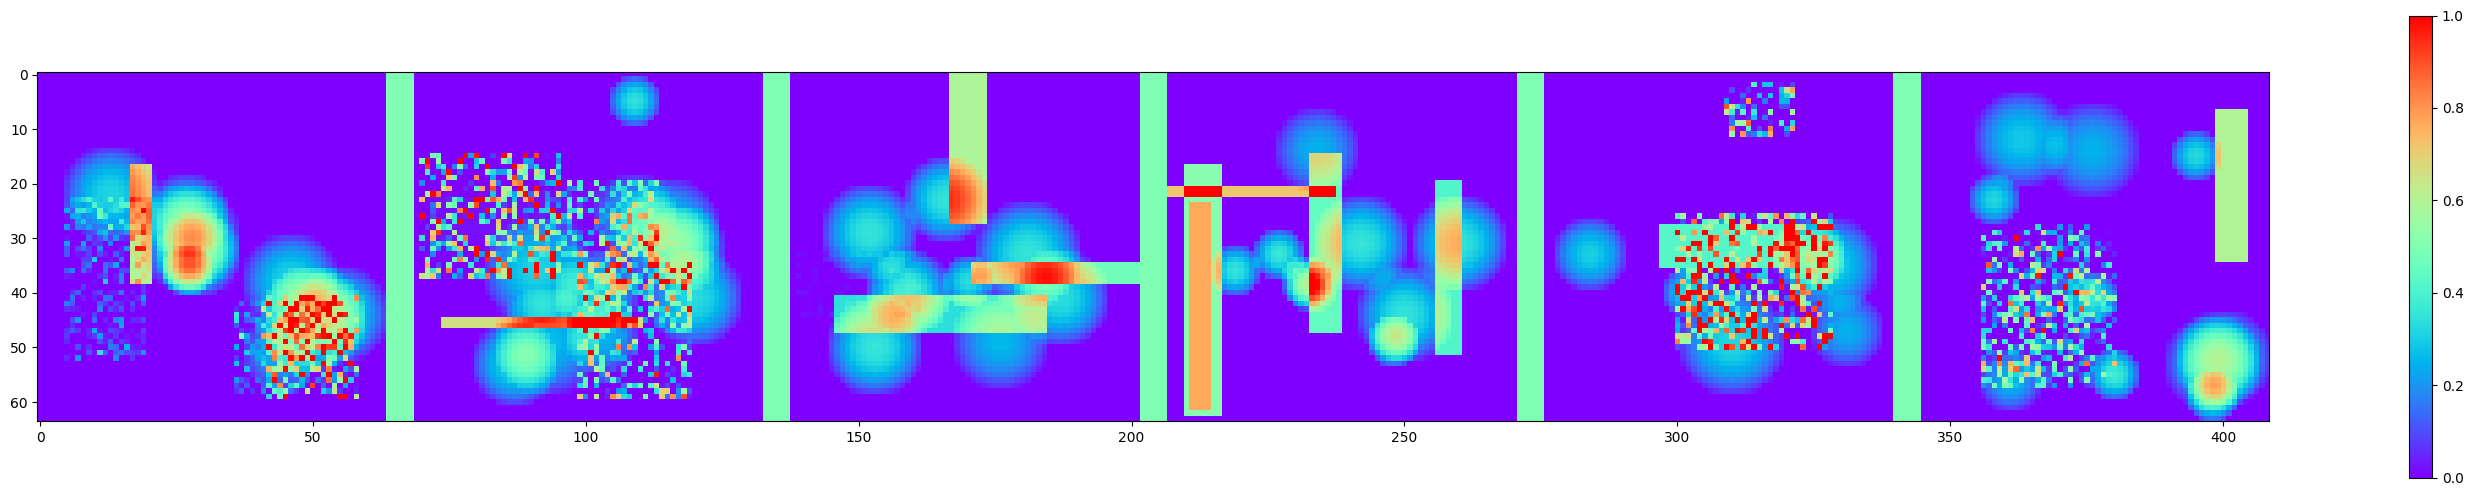

In [6]:
image1, image2 = gen_noise2noise(6)
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(image2.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1:** Define a learning procedure that effectively denoises the image.

In [7]:
fcn = UNet(1,1,16).cuda()

import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [8]:
nepochs = 40
nbatches = 100
batchsize = 64

train_losses = []


def criterion(output,target):
  return torch.mean(torch.abs(output-target))  # idea: use the MAE loss to target the conditionnal median

for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):
        #Load inputs

        # Generation
        input,target = gen_noise2noise(batchsize)

        # go to GPU
        input = input.cuda()
        target = target.cuda()

        # zeroing gradients, forward pass
        optimizer.zero_grad()
        output = fcn(input)

        # loss and compuation of gradients
        loss = criterion(output,target)
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.11379603
Epoch 1
epoch loss : 

0.090108626
Epoch 2
epoch loss : 

0.08584952
Epoch 3
epoch loss : 

0.08512888
Epoch 4
epoch loss : 

0.08300039
Epoch 5
epoch loss : 

0.08289473
Epoch 6
epoch loss : 

0.082354784
Epoch 7
epoch loss : 

0.082432956
Epoch 8
epoch loss : 

0.08042496
Epoch 9
epoch loss : 

0.08220186
Epoch 10
epoch loss : 

0.080822155
Epoch 11
epoch loss : 

0.0797483
Epoch 12
epoch loss : 

0.07952059
Epoch 13
epoch loss : 

0.080890544
Epoch 14
epoch loss : 

0.08035944
Epoch 15
epoch loss : 

0.08061776
Epoch 16
epoch loss : 

0.080357544
Epoch 17
epoch loss : 

0.07960499
Epoch 18
epoch loss : 

0.079699665
Epoch 19
epoch loss : 

0.079390876
Epoch 20
epoch loss : 

0.07890241
Epoch 21
epoch loss : 

0.07888335
Epoch 22
epoch loss : 

0.078701764
Epoch 23
epoch loss : 

0.078021534
Epoch 24
epoch loss : 

0.07867978
Epoch 25
epoch loss : 

0.07964962
Epoch 26
epoch loss : 

0.07916061
Epoch 27
epoch loss : 

0.07823163
Epoch 28
epoch loss :

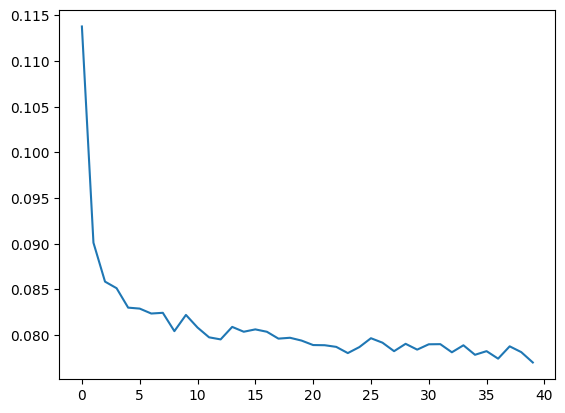

In [9]:
plt.plot(train_losses)

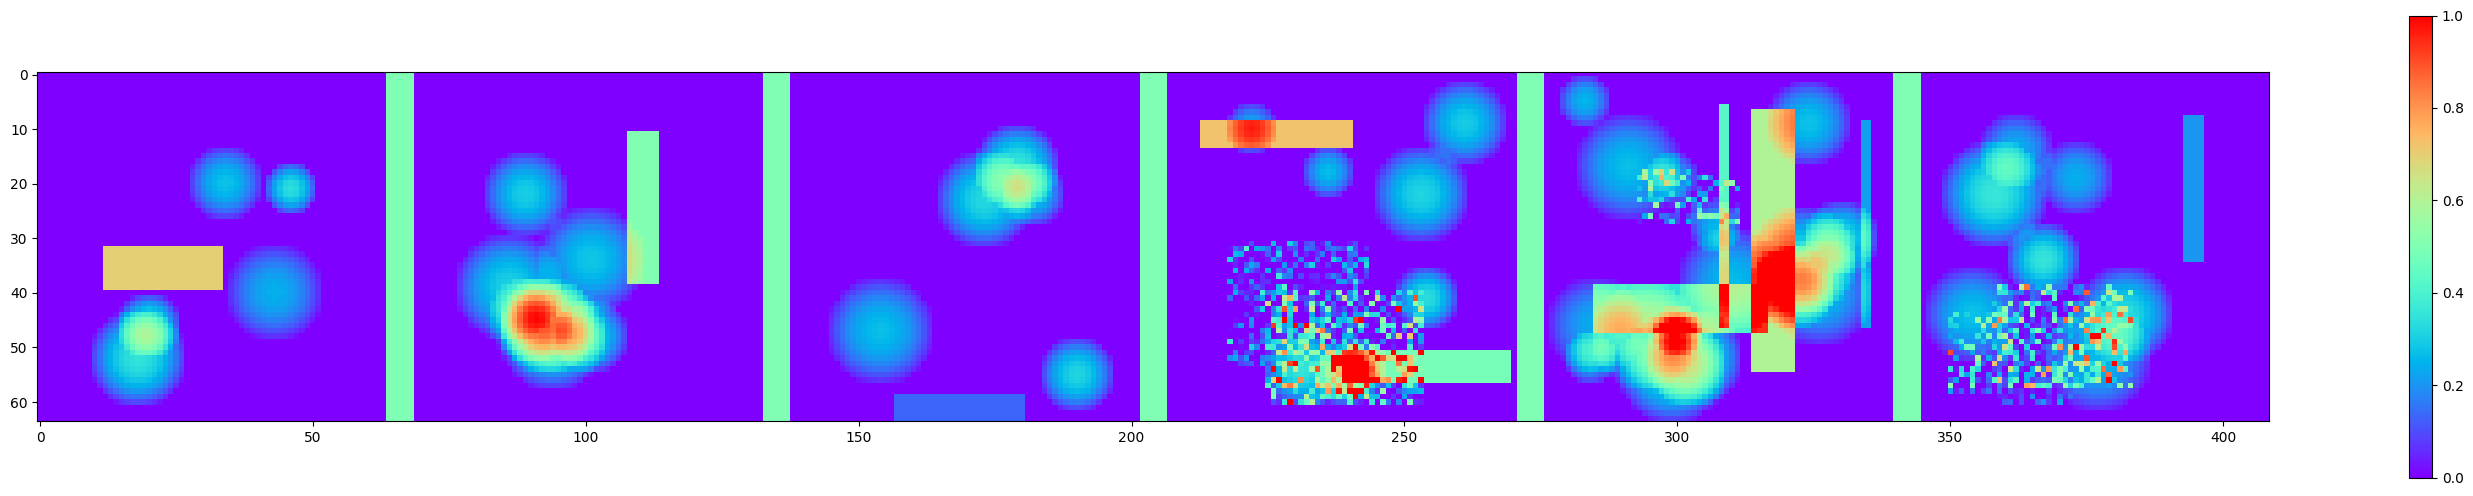

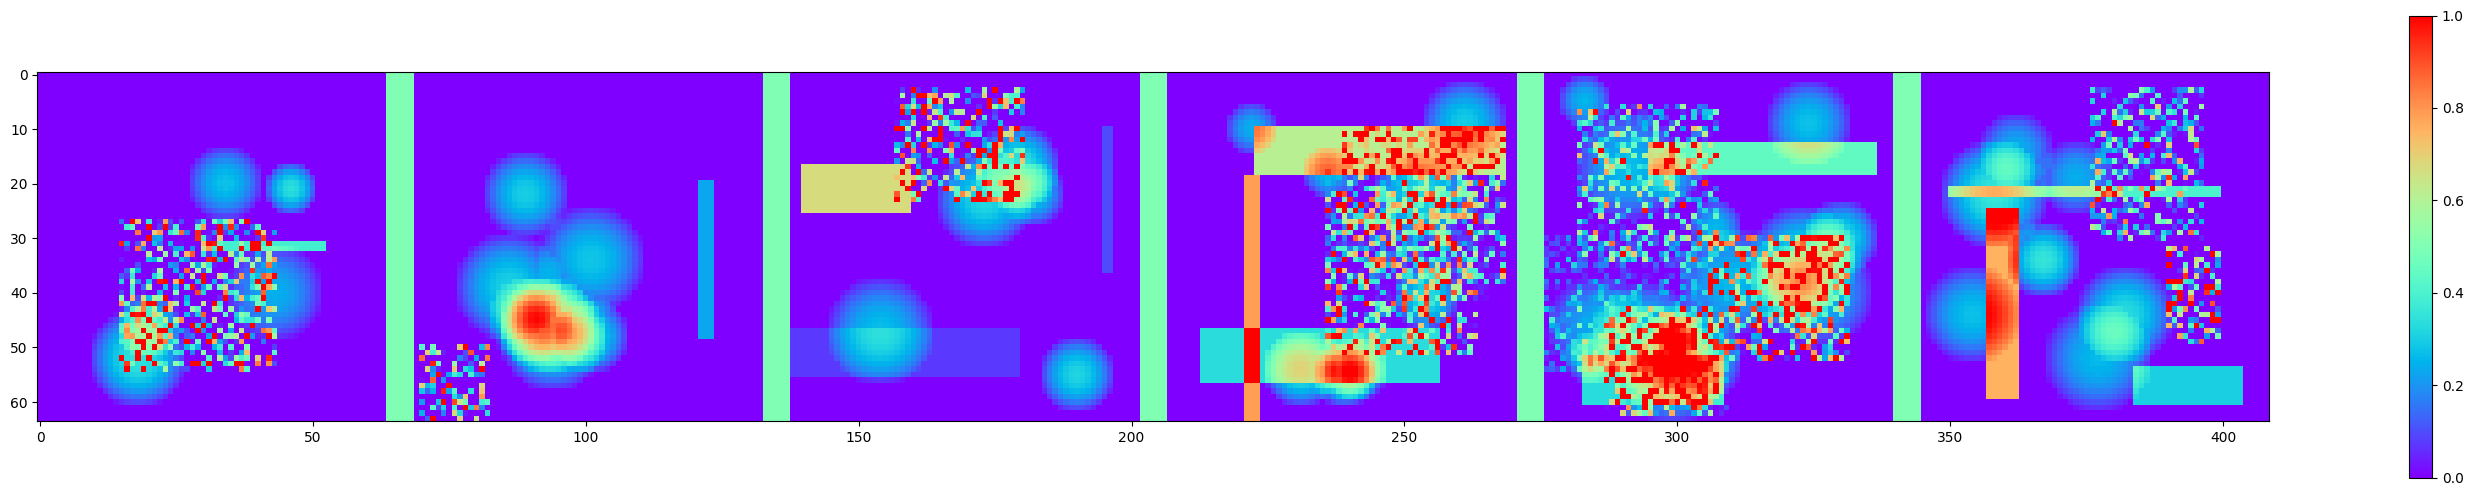

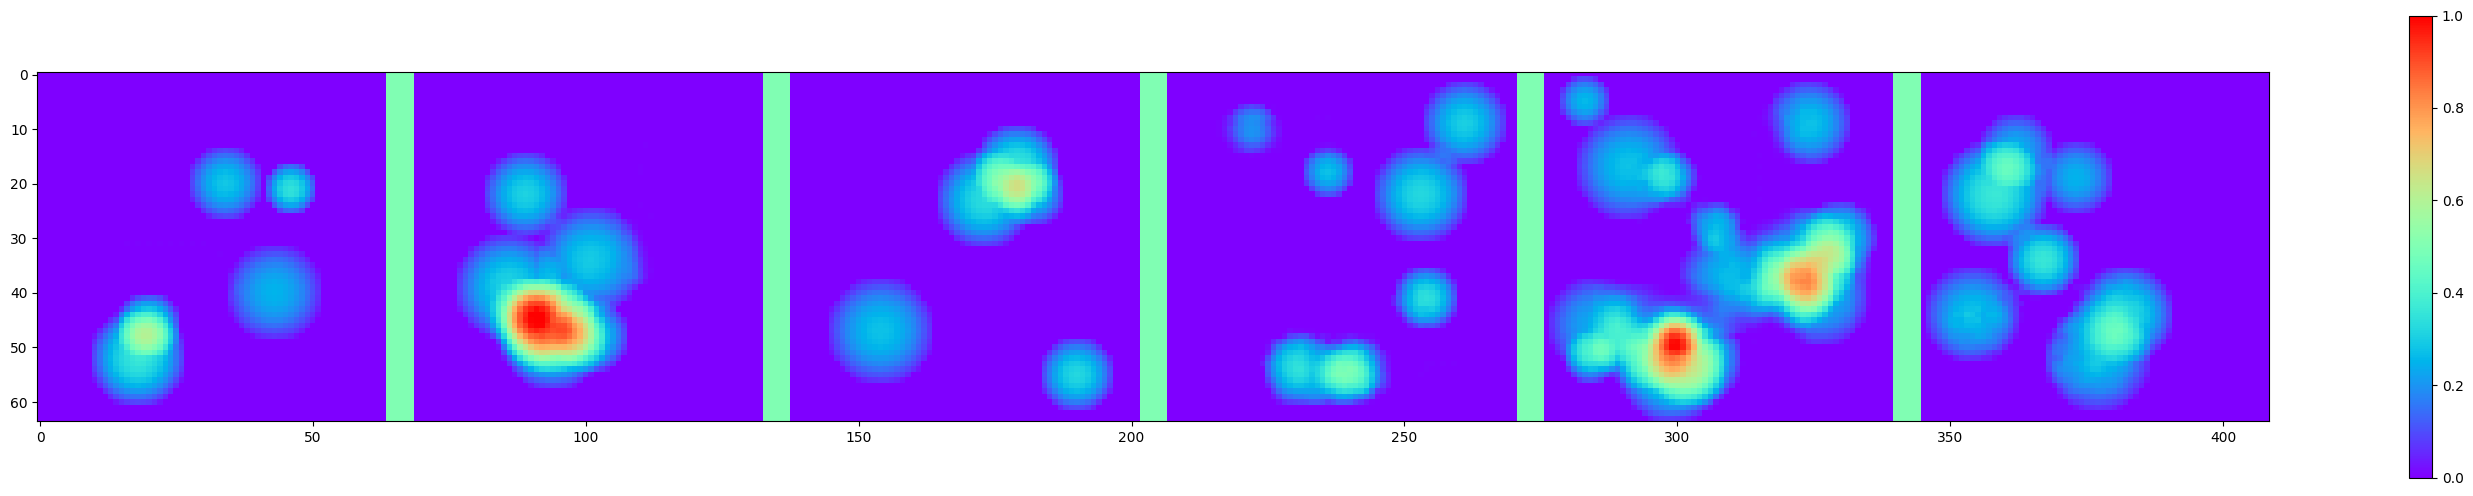

In [10]:
# viz:

fcn.eval()

input, target = gen_noise2noise(6)

output = fcn(input.cuda())


fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)  # inputs
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=0,max_scale=1)  # targets
fig3 = plt.figure(2, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1) # outputs


**Q2:** Theoretical analysis:

The training procedure involves searching for the weights $\theta^*$ that satisfy:

\begin{equation}
\theta^* = \underset{\theta}{argmin} {\big \{} \mathbb{E}_{(X,Y)}[ \ \mathcal{L} (f_\theta(X), Y) \ ] {\big \}} \tag{1}
\end{equation}

Rewrite equation (1) to justify the approach taken for **Q1**.



We rewrite the expectation to be minimized in the case of a cost function equal to the Mean Absolute Error (MAE):

\begin{equation}
 \mathbb{E}_{(X,Y)}[ \ \mathcal{L} (f_\theta(X), Y) \ ] = \mathbb{E}_{X}[ \mathbb{E}_{Y | X}\ |f_\theta(X) - Y | \ ]
\end{equation}

To reach the minimum, the network must provide the conditional median of Y given X. As the probability of being affected by a clutter is less than 0.5 (in this simple version of the scenario), the conditional median targeted by the network is the clean target !

In the case of a quadratic cost function, the network will suggest the conditional expectation. Unlike the median, this is biased, as clutter always contribute positively.


###**Exercise 2: The "NES" scenario (Neural Egg Separation)**

In another scenario, two sources of images can be sampled independently. The first provides noisy images containing the object of interest. Images from the second source contain only noise. Additionally, the corruption process, i.e., how the noise is combined with the clean image, is assumed to be known. This is a relatively common scenario. For instance, in the case of meteorological radar images, it is possible to extract images containing only noise during non-precipitation periods.

This scenario was defined by [Halperin et al (2018)](https://arxiv.org/pdf/1811.12739.pdf). These authors propose an iterative method to address it (Neural Egg Separation). In this exercise, we will rely on a fairly similar principle, still using our synthetic images.

The functions gen1_NES and gen2_NES allow sampling from the two sources. The corruption process is trivial: the noise (rectangles) is simply added to the clean image (cells).   



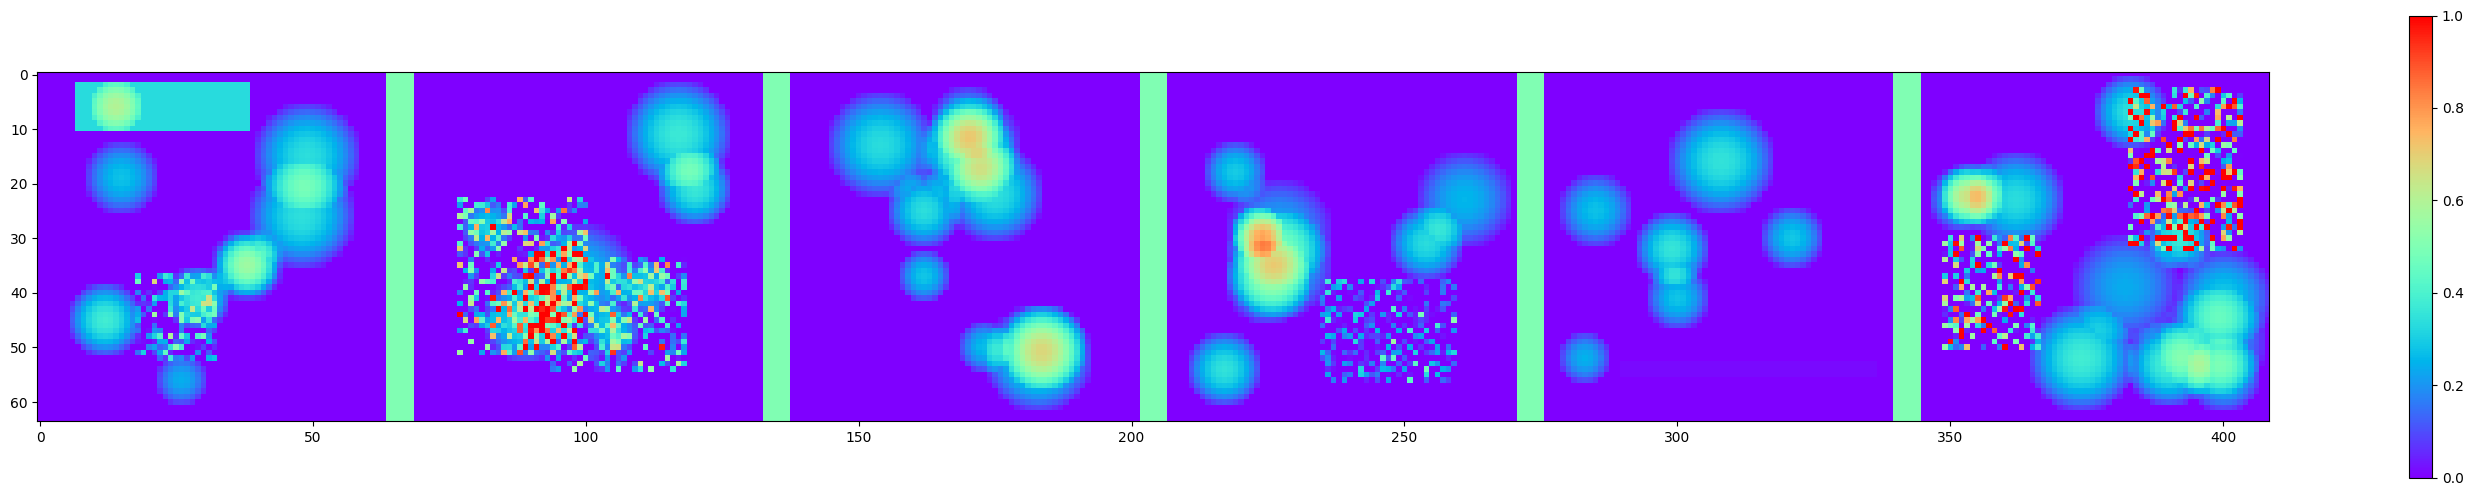

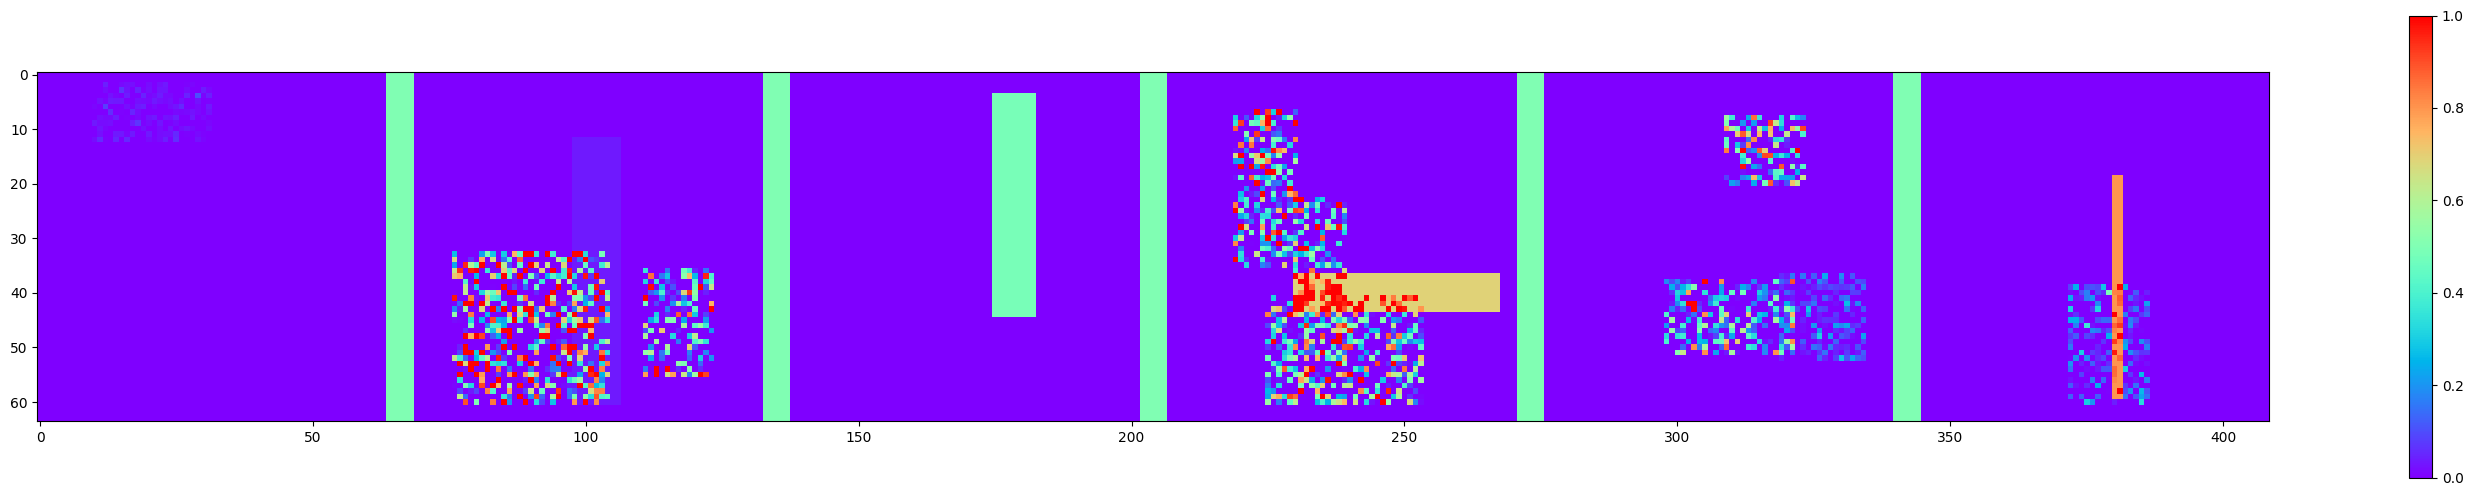

In [12]:
from utile import gen1_NES, gen2_NES
image1 = gen1_NES(6)
noise = gen2_NES(6)

# sample noisy pictures:
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

# sample noise:
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(noise, 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1:** Propose a learning strategy that leads to effective denoising.

**Q2:** Discuss the limitations of the method and mention some avenues for improvement.

The idea is to add images containing noise and target the original image. By adding enough noise so that the additional artifacts dominate and by choosing the cost function appropriately, the network learns to denoise:

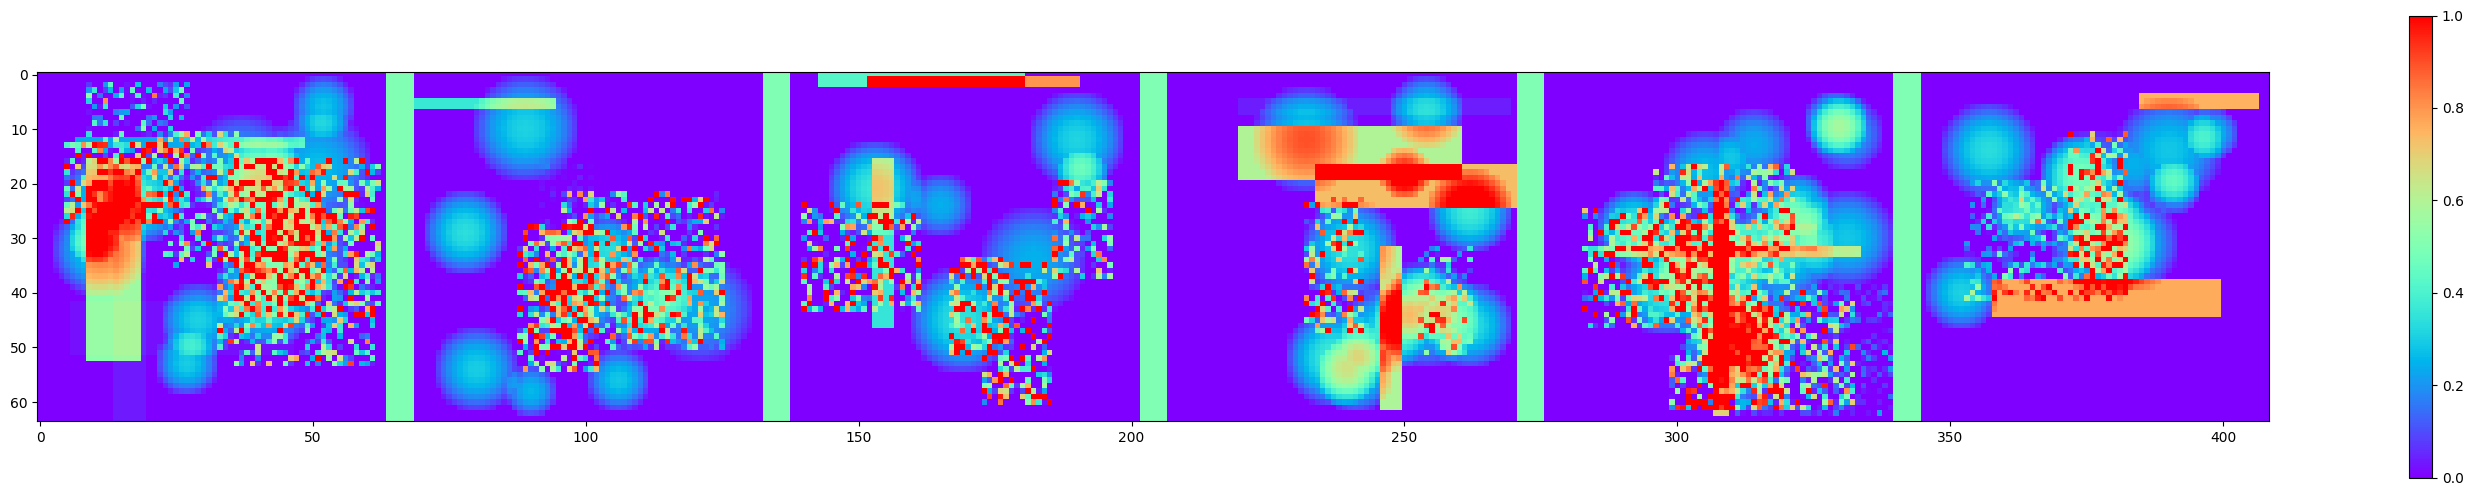

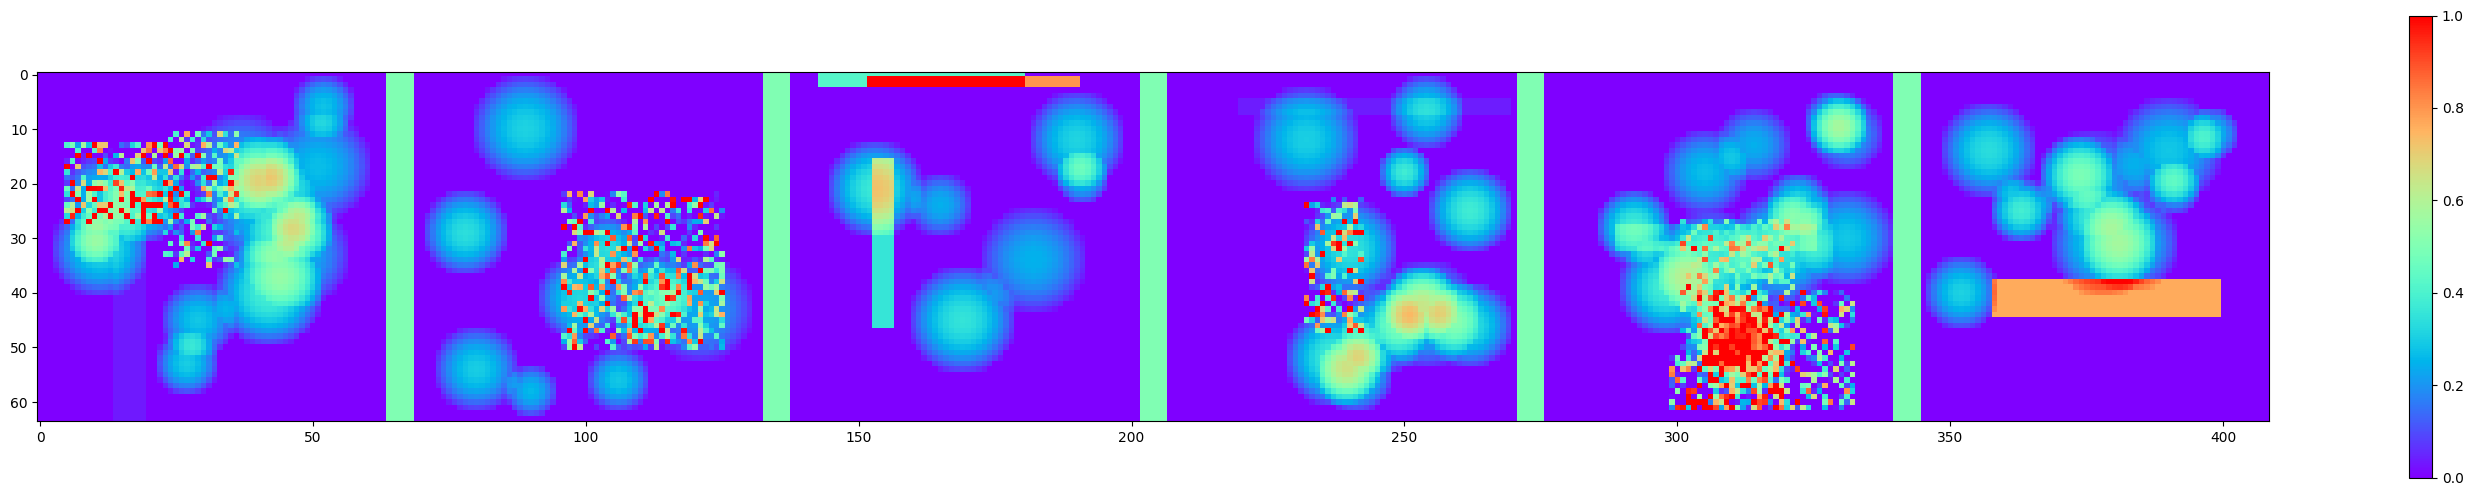

In [13]:
# Examples of (input, target) couples:

batchsize = 6
# Get image + noise and additional noises
image = gen1_NES(batchsize)
noise = gen2_NES(batchsize)
noise2 = gen2_NES(batchsize)

# Build input and targets
input = image + noise + noise2
target = image

# inputs
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)

# targets
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=0,max_scale=1)

In [14]:
fcn = UNet(1,1,16).cuda()  #1 canal entrée, 1 canal de sortie, paramètre taille du réseau: 16

import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [15]:
def criterion(output,target):
  return torch.mean(torch.abs(output-target))  # again, hope the conditionnal median
                                               # is a good estimator.

nepochs = 40
nbatches = 100
batchsize = 64

train_losses = []


for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize

        # generation
        image = gen1_NES(batchsize).cuda()
        noise = gen2_NES(batchsize).cuda()
        noise2 = gen2_NES(batchsize).cuda()

        # build the sum
        input = image + noise + noise2  #on ajoute deux images de bruit
        target = image

        # zeroing gradients, forward pass
        optimizer.zero_grad()
        output = fcn(input)

        # loss, gradients
        loss = criterion(output,target)
        loss.backward()

        # update weights
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.08721525
Epoch 1
epoch loss : 

0.06258176
Epoch 2
epoch loss : 

0.058880944
Epoch 3
epoch loss : 

0.055312786
Epoch 4
epoch loss : 

0.054969843
Epoch 5
epoch loss : 

0.053223956
Epoch 6
epoch loss : 

0.053231455
Epoch 7
epoch loss : 

0.05253534
Epoch 8
epoch loss : 

0.051849585
Epoch 9
epoch loss : 

0.05158993
Epoch 10
epoch loss : 

0.050883904
Epoch 11
epoch loss : 

0.051420573
Epoch 12
epoch loss : 

0.05018978
Epoch 13
epoch loss : 

0.049878087
Epoch 14
epoch loss : 

0.05018772
Epoch 15
epoch loss : 

0.050389938
Epoch 16
epoch loss : 

0.050418936
Epoch 17
epoch loss : 

0.050053187
Epoch 18
epoch loss : 

0.051006168
Epoch 19
epoch loss : 

0.05069465
Epoch 20
epoch loss : 

0.049579993
Epoch 21
epoch loss : 

0.04881162
Epoch 22
epoch loss : 

0.049284223
Epoch 23
epoch loss : 

0.049199376
Epoch 24
epoch loss : 

0.04878129
Epoch 25
epoch loss : 

0.048550077
Epoch 26
epoch loss : 

0.048937406
Epoch 27
epoch loss : 

0.04863455
Epoch 28
epo

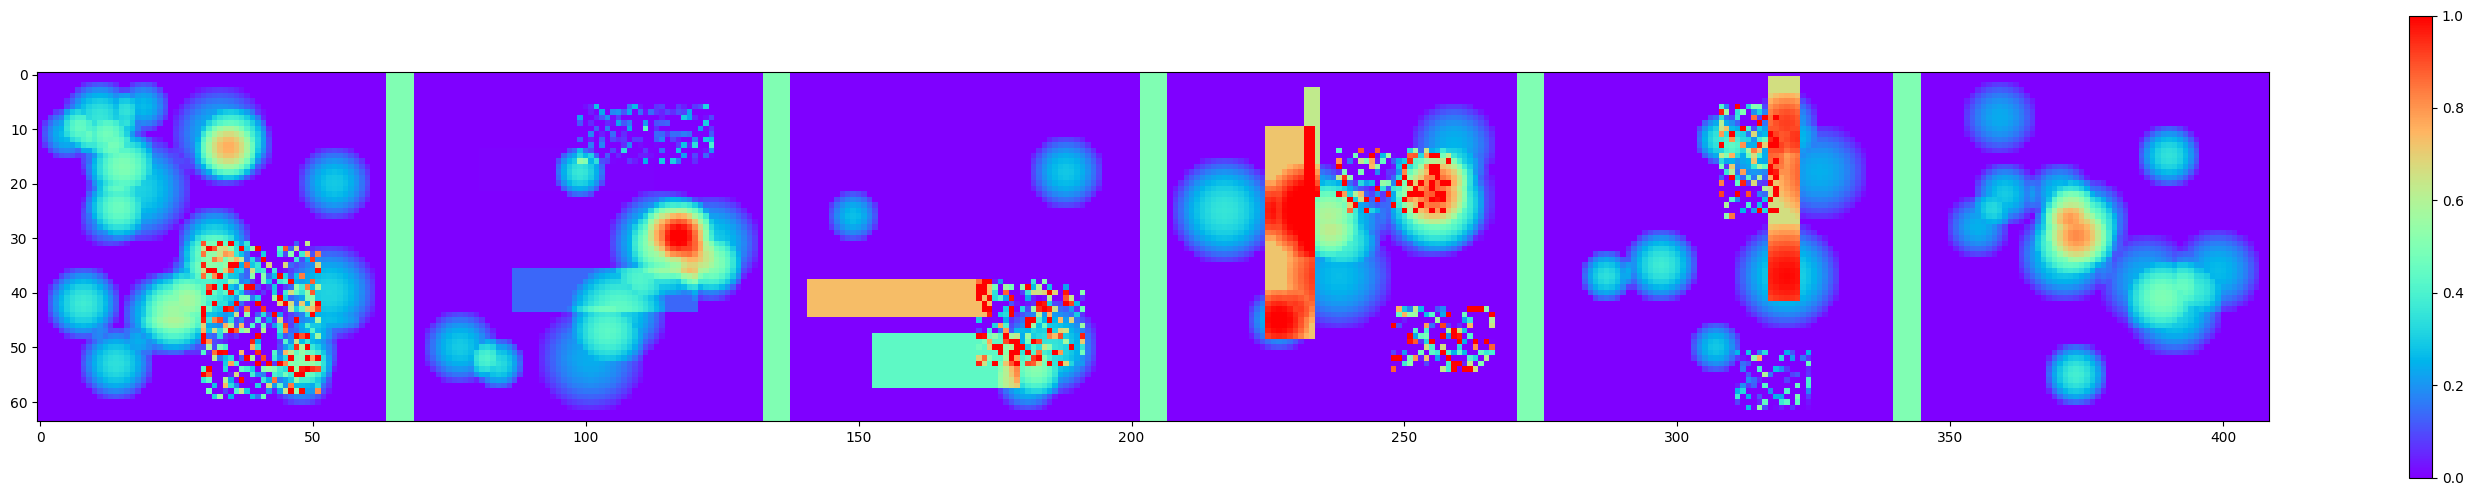

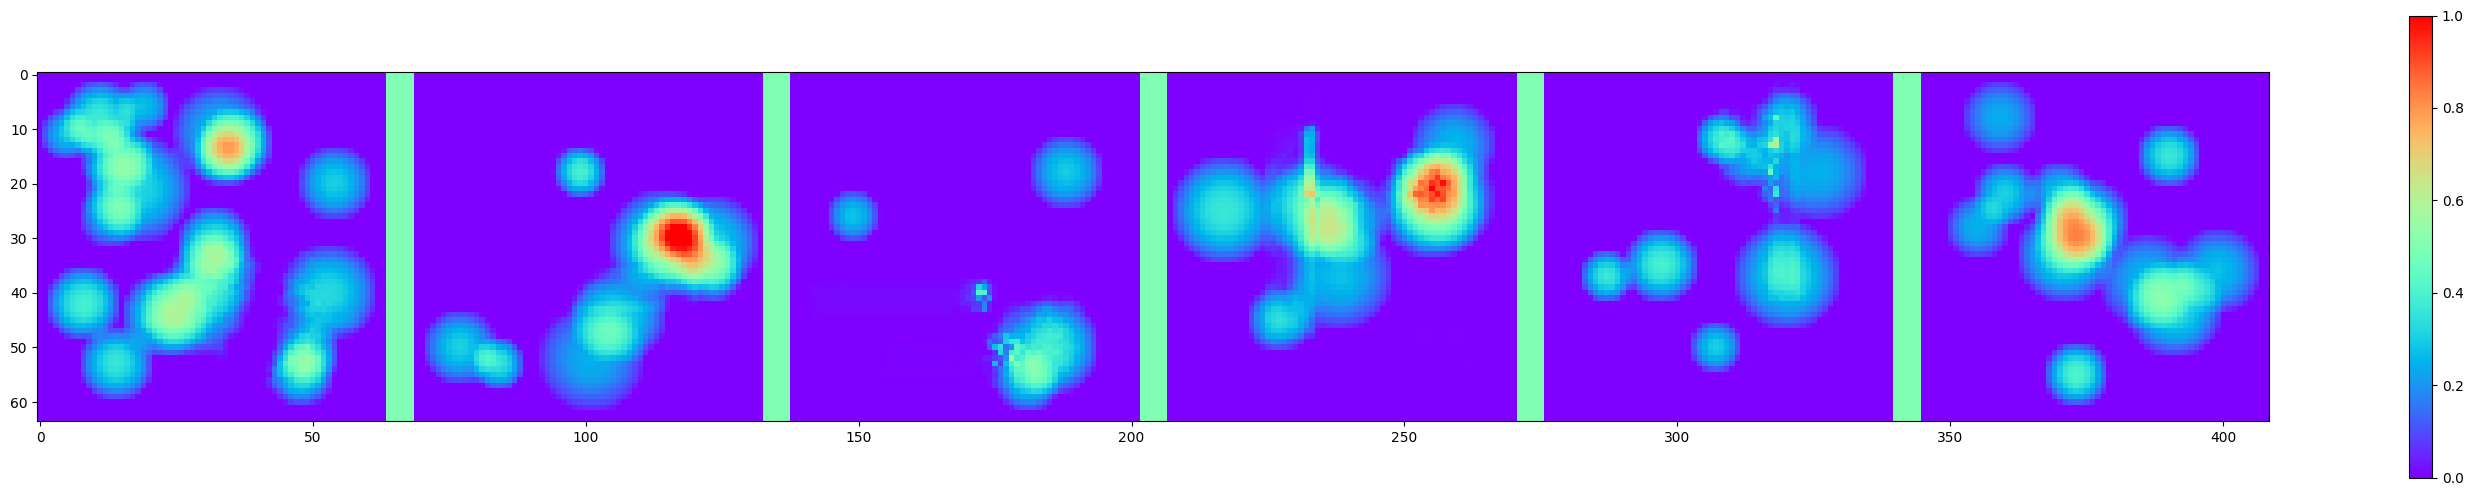

In [16]:
# viz:

fcn.eval()
input = gen1_NES(6)
output = fcn(input.cuda())



fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)

fig3 = plt.figure(2, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)

We can see that the reconstruction is not entirely perfect. However, these imperfections are explainable! When an overlap occurs, there is more than a fifty-fifty chance that at least one of the two patterns is present in the original image. To improve the processing, there are several methods. Exercise sheet number 2 provides an opportunity to explore one of them.